In [ ]:
# !pip install altair
# # Install meridian: from PyPI @ latest release
# !pip install --upgrade google-meridian[colab,and-cuda]

In [362]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az
import datetime
import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 25.8 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


In [363]:
# Connect To Drive

In [364]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# # Assuming your CSV file is in the 'MyDrive' folder
# file_path = '/content/drive/MyDrive/mmm_train_all.csv'
# # Read the CSV file into a pandas DataFrame
# raw_data = pd.read_csv(file_path)

In [365]:
# Assuming your CSV file is in the 'MyDrive' folder
#file_path = '/content/drive/MyDrive/mmm_train_all.csv'
file_path = 'mmm_train_all.csv'
# Read the CSV file into a pandas DataFrame
raw_data = pd.read_csv(file_path)

In [366]:
raw_data.shape

(335, 31)

In [367]:
raw_data = raw_data.drop_duplicates()
raw_data.shape

(335, 31)

In [368]:
raw_data.columns

Index(['Unnamed: 0', 'model_week', 'date', 'iso_week', 'iso_year',
       'ga4_sessions', 'podcast_streams', 'linkedin_spend',
       'linkedin_impressions', 'linkedin_clicks', 'gSearch_sessions',
       'gSearch_impressions', 'gift_spend', 'email_sent_cnt', 'direct_spend',
       'fb_spend', 'fb_impressions', 'fb_clicks', 'googleAds_spend',
       'googleAds_impressions', 'event_spend', 'mql_count', 'mql_restricted',
       'impactDotCom_ga4_sessions', 'month', 'daily_avg_queries',
       'inflation_rate', 'durable_goods_rates', 'consumer_sentiment_index',
       'averageMQL', 'smoothed_MQL'],
      dtype='object')

# Raw Data Import

In [369]:
# Assuming your DataFrame has a date column called 'date'
df = raw_data.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Find gaps larger than 1 day
df['date_diff'] = df['date'].diff().dt.days
non_sequential = df[df['date_diff'] > 1]
print(non_sequential)

Empty DataFrame
Columns: [Unnamed: 0, model_week, date, iso_week, iso_year, ga4_sessions, podcast_streams, linkedin_spend, linkedin_impressions, linkedin_clicks, gSearch_sessions, gSearch_impressions, gift_spend, email_sent_cnt, direct_spend, fb_spend, fb_impressions, fb_clicks, googleAds_spend, googleAds_impressions, event_spend, mql_count, mql_restricted, impactDotCom_ga4_sessions, month, daily_avg_queries, inflation_rate, durable_goods_rates, consumer_sentiment_index, averageMQL, smoothed_MQL, date_diff]
Index: []

[0 rows x 32 columns]


# Daily Data Model

In [370]:
raw_data.columns

Index(['Unnamed: 0', 'model_week', 'date', 'iso_week', 'iso_year',
       'ga4_sessions', 'podcast_streams', 'linkedin_spend',
       'linkedin_impressions', 'linkedin_clicks', 'gSearch_sessions',
       'gSearch_impressions', 'gift_spend', 'email_sent_cnt', 'direct_spend',
       'fb_spend', 'fb_impressions', 'fb_clicks', 'googleAds_spend',
       'googleAds_impressions', 'event_spend', 'mql_count', 'mql_restricted',
       'impactDotCom_ga4_sessions', 'month', 'daily_avg_queries',
       'inflation_rate', 'durable_goods_rates', 'consumer_sentiment_index',
       'averageMQL', 'smoothed_MQL'],
      dtype='object')

In [371]:
raw_data['scaled_mqls'] = raw_data['mql_count']*100
y1 =  raw_data['scaled_mqls']
y = raw_data['mql_count'].to_numpy()
y2 = raw_data['linkedin_spend'].to_numpy()
x = raw_data['date'].to_numpy()

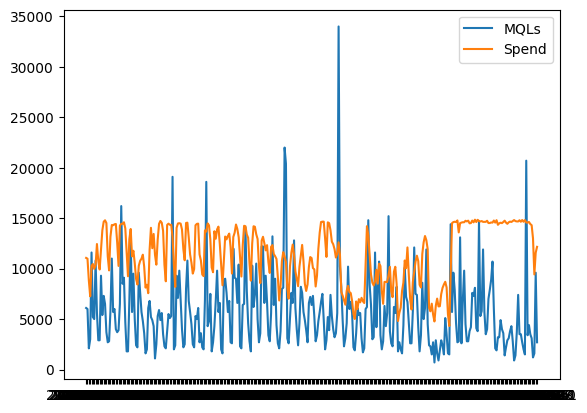

In [372]:
plt.plot(x, y1, label='MQLs')
plt.plot(x, y2, label='Spend')
plt.legend()
plt.show()

/var/folders/rt/jvrnppjd0lx_hpnwh05y501m0000gn/T/ipykernel_99470/1526181892.py:2: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


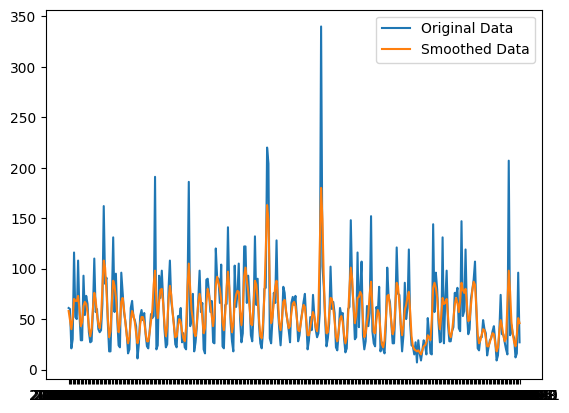

In [373]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt

smoothed_y = gaussian_filter1d(y, sigma=1)

plt.plot(x, y, label='Original Data')
plt.plot(x, smoothed_y, label='Smoothed Data')
plt.legend()
plt.show()

# Daily Data

In [374]:
raw_data.columns

Index(['Unnamed: 0', 'model_week', 'date', 'iso_week', 'iso_year',
       'ga4_sessions', 'podcast_streams', 'linkedin_spend',
       'linkedin_impressions', 'linkedin_clicks', 'gSearch_sessions',
       'gSearch_impressions', 'gift_spend', 'email_sent_cnt', 'direct_spend',
       'fb_spend', 'fb_impressions', 'fb_clicks', 'googleAds_spend',
       'googleAds_impressions', 'event_spend', 'mql_count', 'mql_restricted',
       'impactDotCom_ga4_sessions', 'month', 'daily_avg_queries',
       'inflation_rate', 'durable_goods_rates', 'consumer_sentiment_index',
       'averageMQL', 'smoothed_MQL', 'scaled_mqls'],
      dtype='object')

In [386]:
data = raw_data[['date', 'podcast_streams', 'linkedin_spend',
        'gift_spend', 'email_sent_cnt', 'direct_spend',
       'fb_spend', 'googleAds_spend', 'event_spend', 'mql_count',
       'impactDotCom_ga4_sessions',  'daily_avg_queries',  'consumer_sentiment_index', 
       'inflation_rate','durable_goods_rates']].copy()
data['event_happened'] = np.where(data['event_spend']>1,1,0)
data['revenueProxy'] = data['mql_count'] * 1000


In [387]:
data['average_mql_count'] = (data['mql_count'].shift(1) + data['mql_count'].shift(-1)) / 2
data['average_mql_count'] = data['average_mql_count'].fillna(data['mql_count'])
data['smoothed_mql_count'] = np.where(data['mql_count']>100,data['mql_count'] , data['mql_count'])
data['revenue_proxy_smoothed_mql_counts'] = data['smoothed_mql_count'] * 1000


In [388]:
data['date'] =  data['date'].apply(lambda x:  datetime.datetime.strptime(x,"%Y-%m-%d"))

In [389]:
yearEndCols = ['consumer_sentiment_index', 'durable_goods_rates','inflation_rate' ]
for col in yearEndCols:
    m = data[col].mean()
    data[col] = data[col].fillna(m)
    # print(data[data[col].isnull()==True])

In [390]:
data = pd.concat((data, pd.get_dummies(data['date'].dt.day_name())), axis=1)

In [391]:
data['weekend'] = np.where(data['Saturday']==True, True, False)
data['weekend'] = np.where(data['Sunday']==True, True, data['weekend'])


data['longWeekend'] = np.where(data['Saturday']==True, True, False)
data['longWeekend'] = np.where(data['Sunday']==True, True, data['longWeekend'])
data['longWeekend'] = np.where(data['Friday']==True, True, data['longWeekend'])

In [392]:
# Assuming your DataFrame has a date column called 'date'
df = data.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Find gaps larger than 1 day
df['date_diff'] = df['date'].diff().dt.days
non_sequential = df[df['date_diff'] > 1]
print(non_sequential)

Empty DataFrame
Columns: [date, podcast_streams, linkedin_spend, gift_spend, email_sent_cnt, direct_spend, fb_spend, googleAds_spend, event_spend, mql_count, impactDotCom_ga4_sessions, daily_avg_queries, consumer_sentiment_index, inflation_rate, durable_goods_rates, event_happened, revenueProxy, average_mql_count, smoothed_mql_count, revenue_proxy_smoothed_mql_counts, Friday, Monday, Saturday, Sunday, Thursday, Tuesday, Wednesday, weekend, longWeekend, date_diff]
Index: []

[0 rows x 30 columns]


In [393]:
# Data Load

In [394]:
organic_vars = ['podcast_streams', 'email_opened_cnt', 'impactDotCom_ga4_sessions']
predictor_var = 'revenue_proxy_smoothed_mql_counts'

In [395]:
# STEP 2: LOAD AND PREPARE YOUR DATA

# Replace 'my_data.csv' with the path to your actual dataset
# data = pd.read_csv('/Users/gabriele/Downloads/dataset-ms - dataset-ms.csv')

# # Identify columns that contain spend-related keywords (e.g., 'spend', 'cost', 'budget')
media = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['spend', 'cost', 'budget'])
]
impressions = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['impressions'])
]

# Exclude media channels with zero total spend
media = [col for col in media if data[col].sum() > 0]

# Example: define any organic or additional columns you may want to handle
organic = organic_vars
#organic = ['podcast_streams', 'email_opened_cnt']

# Print and verify selected media channels
print("Selected Media Channels:", media)

# # Convert date column to datetime
# data['date_week'] = pd.to_datetime(data['date_week'])
data['date_week'] =  data['date']

# # Identify the output (revenue) column(s)
output = [
    col for col in data.columns
    if 'revenue' in col.lower()
]

# Identify the output (revenue) column(s)
output_var = predictor_var


# Create a time index t
data['t'] = range(len(data))

# Separate features (X) and target (y)
X = data.drop(output_var, axis=1)
y = data[output_var]  # if there is only one revenue column

# Inspect columns
data.head()

Selected Media Channels: ['linkedin_spend', 'gift_spend', 'direct_spend', 'fb_spend', 'googleAds_spend', 'event_spend']


,date,podcast_streams,linkedin_spend,gift_spend,email_sent_cnt,direct_spend,fb_spend,googleAds_spend,event_spend,mql_count,...,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,weekend,longWeekend,date_week,t
0,2024-04-11,332.0,11063.50,0.00,0.0,9000.0,2169.57,6448.16,0.0,61,...,False,False,False,True,False,False,False,False,2024-04-11,0
1,2024-04-12,227.0,10985.40,498.86,0.0,0.0,2189.92,4544.18,0.0,60,...,False,False,False,False,False,False,False,True,2024-04-12,1
2,2024-04-13,186.0,8826.29,0.00,0.0,0.0,2140.88,1676.13,0.0,21,...,False,True,False,False,False,False,True,True,2024-04-13,2
3,2024-04-14,120.0,7257.84,0.00,0.0,0.0,2404.75,2054.01,0.0,30,...,False,False,True,False,False,False,True,True,2024-04-14,3
4,2024-04-15,182.0,10275.43,339.42,0.0,0.0,2307.37,5510.42,0.0,116,...,True,False,False,False,False,False,False,False,2024-04-15,4


In [354]:
data[data.isnull().any(axis=1)]

,date,podcast_streams,linkedin_spend,gift_spend,email_sent_cnt,direct_spend,fb_spend,googleAds_spend,event_spend,mql_count,...,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,weekend,longWeekend,date_week,t


In [396]:
allCols = data.columns
for col in allCols:
    if data[data[col].isnull()==True].shape[0]>0:
        print(data[data[col].isnull()==True])

In [397]:
numeric_df = data.select_dtypes(include=np.number)
numeric_df

,podcast_streams,linkedin_spend,gift_spend,email_sent_cnt,direct_spend,fb_spend,googleAds_spend,event_spend,mql_count,impactDotCom_ga4_sessions,daily_avg_queries,consumer_sentiment_index,inflation_rate,durable_goods_rates,event_happened,revenueProxy,average_mql_count,smoothed_mql_count,revenue_proxy_smoothed_mql_counts,t
0,332.0,11063.50,0.00,0.0,9000.0,2169.57,6448.16,0.0,61,4972.0,16753.0,77.2,0.0336,0.0022,0,61000,61.0,61,61000,0
1,227.0,10985.40,498.86,0.0,0.0,2189.92,4544.18,0.0,60,4538.0,16753.0,77.2,0.0336,0.0022,0,60000,41.0,60,60000,1
2,186.0,8826.29,0.00,0.0,0.0,2140.88,1676.13,0.0,21,2430.0,16753.0,77.2,0.0336,0.0022,0,21000,45.0,21,21000,2
3,120.0,7257.84,0.00,0.0,0.0,2404.75,2054.01,0.0,30,2546.0,16753.0,77.2,0.0336,0.0022,0,30000,68.5,30,30000,3
4,182.0,10275.43,339.42,0.0,0.0,2307.37,5510.42,0.0,116,7164.0,16753.0,77.2,0.0336,0.0022,0,116000,41.0,116,116000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,85.0,14307.41,0.00,0.0,0.0,1733.94,3908.57,0.0,31,2955.0,12539.0,57.0,0.0239,0.0936,0,31000,23.5,31,31000,330
331,64.0,13003.80,0.00,0.0,0.0,1796.12,2200.39,0.0,12,2030.0,12539.0,57.0,0.0239,0.0936,0,12000,23.5,12,12000,331
332,130.0,9425.18,0.00,0.0,0.0,1923.35,2239.74,0.0,16,1587.0,12539.0,57.0,0.0239,0.0936,0,16000,54.0,16,16000,332
333,94.0,11580.42,779.00,0.0,7000.0,1849.55,5553.14,0.0,96,3876.0,12539.0,57.0,0.0239,0.0936,0,96000,21.5,96,96000,333


## Collinearity

******** Spend Share Analysis ********
     Media_Channel  Spend_Share
0   linkedin_spend     0.510996
1       gift_spend     0.011892
2     direct_spend     0.142351
3         fb_spend     0.090379
4  googleAds_spend     0.208683
5      event_spend     0.035698


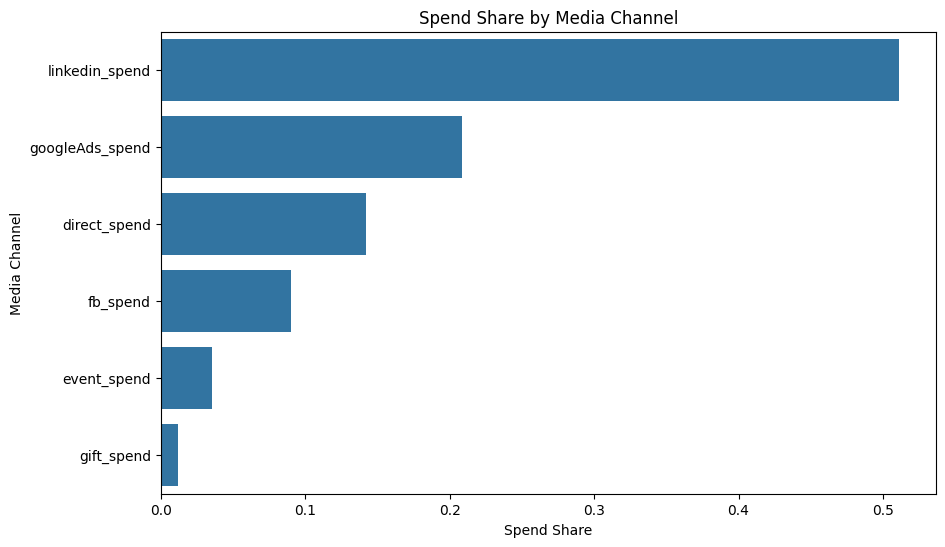


******** Correlation Analysis ********
Using revenue column: revenueProxy
Correlation of inputs with revenueProxy:
mql_count                            1.000000
smoothed_mql_count                   1.000000
revenue_proxy_smoothed_mql_counts    1.000000
googleAds_spend                      0.546044
impactDotCom_ga4_sessions            0.408467
average_mql_count                    0.334318
linkedin_spend                       0.290032
gift_spend                           0.224440
fb_spend                             0.141480
email_sent_cnt                       0.110996
daily_avg_queries                    0.077319
event_happened                       0.053409
event_spend                          0.052236
direct_spend                         0.050764
consumer_sentiment_index             0.037413
podcast_streams                      0.031484
durable_goods_rates                  0.020735
inflation_rate                      -0.044331
t                                   -0.095026
Name: reve

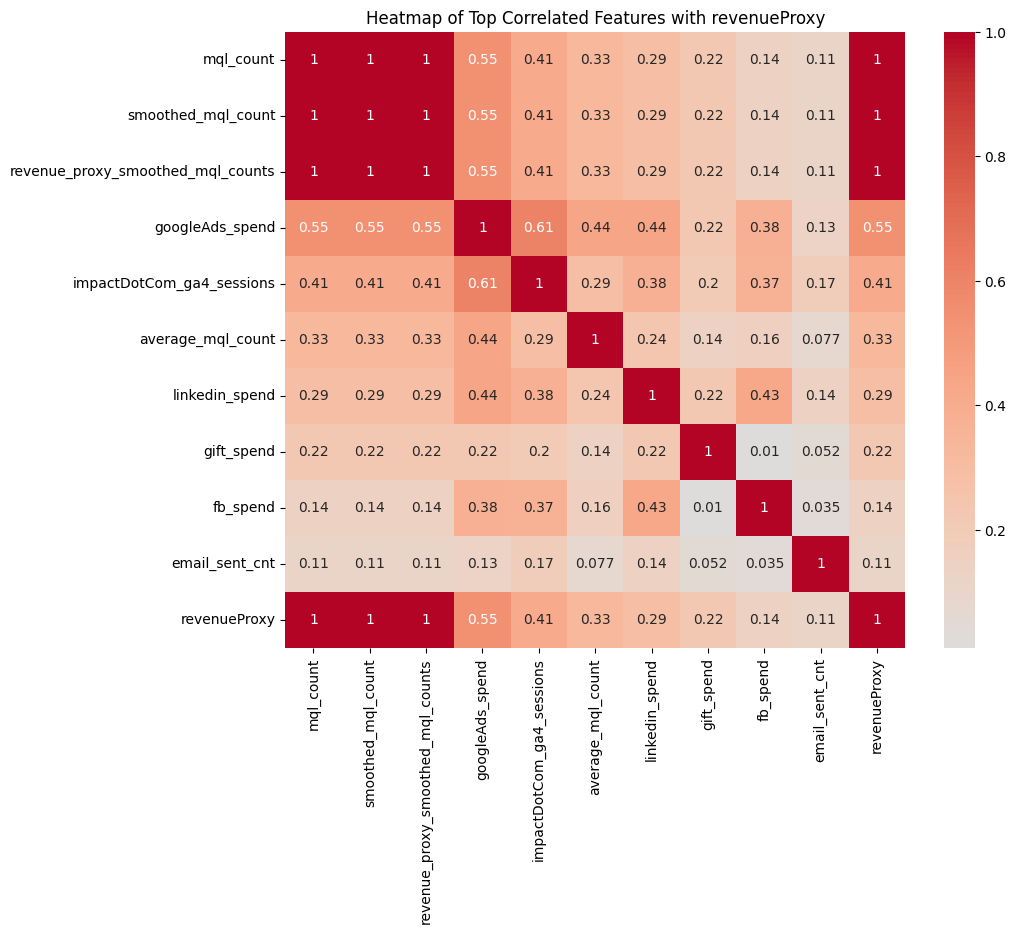


******** Multicollinearity Analysis ********
                      Feature         VIF
17         smoothed_mql_count         inf
15               revenueProxy         inf
8                   mql_count         inf
11   consumer_sentiment_index  334.679641
12             inflation_rate  275.564771
10          daily_avg_queries  152.507664
1              linkedin_spend   49.999456
5                    fb_spend   20.070600
9   impactDotCom_ga4_sessions   19.513847
6             googleAds_spend   18.586940
18                          t   13.213172
16          average_mql_count    7.228461
14             event_happened    2.246571
7                 event_spend    2.202264
13        durable_goods_rates    1.618651
2                  gift_spend    1.516448
0             podcast_streams    1.392438
3              email_sent_cnt    1.111130
4                direct_spend    1.072649

******** Variables with Less Than 15 Records ********
All variables have at least 15 records.


/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [398]:
# Import necessary libraries for visualization and multicollinearity analysis.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ----------------------------
# 1. Spend Share Analysis
# ----------------------------
print("******** Spend Share Analysis ********")
if media:
    # Calculate total spend across all identified media channels.
    total_media_spend = data[media].sum().sum()
    # Compute spend share for each media channel.
    spend_share = data[media].sum() / total_media_spend
    spend_share_df = spend_share.reset_index()
    spend_share_df.columns = ['Media_Channel', 'Spend_Share']
    print(spend_share_df)

    # Plot a bar chart of spend share.
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Spend_Share', y='Media_Channel',
                data=spend_share_df.sort_values(by='Spend_Share', ascending=False))
    plt.title("Spend Share by Media Channel")
    plt.xlabel("Spend Share")
    plt.ylabel("Media Channel")
    plt.show()
else:
    print("No media channels available for spend share analysis.")


# ----------------------------
# 2. Correlation Analysis between Inputs and Output (ecommerce_revenue)
# ----------------------------
print("\n******** Correlation Analysis ********")
# Determine the revenue column (assume that output[0] is the revenue column, as set previously)
revenue_col = output[0] if output and output[0] in data.columns else 'ecommerce_revenue'
print("Using revenue column:", revenue_col)

# Select only numeric features from the complete dataset.
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

if revenue_col in corr_matrix.columns:
    # Calculate correlation of all numeric features with the revenue column.
    corr_with_rev = corr_matrix[revenue_col].drop(labels=[revenue_col]).sort_values(ascending=False)
    print("Correlation of inputs with {}:".format(revenue_col))
    print(corr_with_rev)

    # Identify top 10 features most correlated (by absolute value) with the revenue.
    top_features = corr_with_rev.abs().sort_values(ascending=False).head(10).index.tolist() + [revenue_col]

    # Plot a heatmap displaying correlations among these top features.
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_data[top_features].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title("Heatmap of Top Correlated Features with {}".format(revenue_col))
    plt.show()
else:
    print("Revenue column not found in the correlation matrix.")


# ----------------------------
# 3. Multicollinearity Analysis (Variance Inflation Factor)
# ----------------------------
print("\n******** Multicollinearity Analysis ********")
# Use the feature set X defined earlier; select only numeric columns.
X_numeric = X.select_dtypes(include=[np.number])
if not X_numeric.empty:
    vif_df = pd.DataFrame()
    vif_df["Feature"] = X_numeric.columns
    # Calculate VIF for each feature.
    vif_df["VIF"] = [variance_inflation_factor(X_numeric.values, i)
                     for i in range(X_numeric.shape[1])]
    print(vif_df.sort_values(by="VIF", ascending=False))
else:
    print("No numeric features available in X for multicollinearity analysis.")


# ----------------------------
# 4. Check for Variables with Less Than 15 Records
# ----------------------------
print("\n******** Variables with Less Than 15 Records ********")
low_record_columns = {col: data[col].count() for col in data.columns if data[col].count() < 15}
if low_record_columns:
    for col, cnt in low_record_columns.items():
        print(f"Column '{col}' has only {cnt} recorded non-null entries.")
else:
    print("All variables have at least 15 records.")


In [399]:
# Channel Mappings and Seasonality

In [400]:
def create_channel_mappings(media, impressions):
    """
    Generate mapping dictionaries for media spend and impressions columns.

    Parameters:
        media (list of str): List of column names with spend/cost data.
                             Expected to have columns ending with '_cost'.
        impressions (list of str): List of column names with impressions data.
                                   Expected to have columns ending with '_cost_impressions'.

    Returns:
        tuple: Two dictionaries:
            - correct_media_spend_to_channel: Mapping of cost column names to simplified channel names.
            - correct_media_to_channel: Mapping of impressions column names to simplified channel names.
    """
    correct_media_spend_to_channel = {}
    for col in media:
        if col.endswith("_cost"):
            channel_name = col[:-len("_cost")]
        else:
            channel_name = col
        correct_media_spend_to_channel[col] = channel_name

    correct_media_to_channel = {}
    for col in impressions:
        if col.endswith("_impressions"):
          #substitute
            channel_name = col[:-len("_impressions")]
        else:
            channel_name = col
        correct_media_to_channel[col] = channel_name

    return correct_media_spend_to_channel, correct_media_to_channel



cost_mapping, impressions_mapping = create_channel_mappings(media, impressions)
print("Cost Mapping:", cost_mapping)
print("Impressions Mapping:", cost_mapping)

Cost Mapping: {'linkedin_spend': 'linkedin_spend', 'gift_spend': 'gift_spend', 'direct_spend': 'direct_spend', 'fb_spend': 'fb_spend', 'googleAds_spend': 'googleAds_spend', 'event_spend': 'event_spend'}
Impressions Mapping: {'linkedin_spend': 'linkedin_spend', 'gift_spend': 'gift_spend', 'direct_spend': 'direct_spend', 'fb_spend': 'fb_spend', 'googleAds_spend': 'googleAds_spend', 'event_spend': 'event_spend'}


In [401]:
# def create_seasonality_features(data: pd.DataFrame, date_column: str, output_variable: str, yearly_seasonality: int) -> pd.DataFrame:
#     """
#     Creates seasonality effect features for modeling based on the yearly seasonality using the statsmodels library.

#     Parameters:
#     - data (pd.DataFrame): The input dataframe.
#     - date_column (str): The name of the date column.
#     - output_variable (str): The name of the output variable.
#     - yearly_seasonality (int): The yearly seasonality period (e.g., 52 for weekly, 365 for daily).

#     Returns:
#     - pd.DataFrame: The dataframe with added seasonality features.
#     """
#     from statsmodels.tsa.seasonal import seasonal_decompose

#     # Ensure the date column is in datetime format
#     data[date_column] = pd.to_datetime(data[date_column])

#     # Sort the data by date
#     data = data.sort_values(by=date_column)

#     # Set the date column as index for seasonal decomposition
#     data.set_index(date_column, inplace=True)

#     # Perform seasonal decomposition with multiplicative model
#     decomposition = seasonal_decompose(data[output_variable], model='multiplicative', period=yearly_seasonality)

#     # # Add seasonal component as a feature
#     data[f'seasonal_{output_variable}'] = decomposition.seasonal
#     # data[f'seasonal_{output_variable}'] = 1

#     # Reset index to retain the date column
#     data.reset_index(inplace=True)

#     return data

# # Example usage
# data = create_seasonality_features(
#     data,
#     date_column='date_week',
#     output_variable='mql_count',
#     yearly_seasonality=52
# )

data.head()

,date,podcast_streams,linkedin_spend,gift_spend,email_sent_cnt,direct_spend,fb_spend,googleAds_spend,event_spend,mql_count,...,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,weekend,longWeekend,date_week,t
0,2024-04-11,332.0,11063.50,0.00,0.0,9000.0,2169.57,6448.16,0.0,61,...,False,False,False,True,False,False,False,False,2024-04-11,0
1,2024-04-12,227.0,10985.40,498.86,0.0,0.0,2189.92,4544.18,0.0,60,...,False,False,False,False,False,False,False,True,2024-04-12,1
2,2024-04-13,186.0,8826.29,0.00,0.0,0.0,2140.88,1676.13,0.0,21,...,False,True,False,False,False,False,True,True,2024-04-13,2
3,2024-04-14,120.0,7257.84,0.00,0.0,0.0,2404.75,2054.01,0.0,30,...,False,False,True,False,False,False,True,True,2024-04-14,3
4,2024-04-15,182.0,10275.43,339.42,0.0,0.0,2307.37,5510.42,0.0,116,...,True,False,False,False,False,False,False,False,2024-04-15,4


In [404]:
# Fix the mismatch in controls by renaming 'events' => 'events_events'
# (or whichever naming scheme you prefer if you actually want it to be 'events')

coord_to_columns = load.CoordToColumns(
    time='date',
    kpi='revenueProxy', 
    #revenue_per_kpi='revenueProxy',  # make sure this matches your KPI column in the DataFrame
    controls=['gSearch_sessions','longWeekend'],  # corrected name"
    media=media,
    media_spend=media,
    organic_media=organic,  # or whichever email column you truly nee
)

loader = load.DataFrameDataLoader(
    df=data,
    kpi_type= 'revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=cost_mapping,
    media_spend_to_channel=cost_mapping,
)
data_meridian = loader.load()

/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/data/load.py:896: UserWarning: The `population` argument is ignored in a nationally aggregated model. It will be reset to [1, 1, ..., 1]
  warnings.warn(


ValueError: Values of the `coord_to_columns` object ['date', 'direct_spend', 'direct_spend', 'email_opened_cnt', 'event_spend', 'event_spend', 'fb_spend', 'fb_spend', 'gSearch_sessions', 'geo', 'gift_spend', 'gift_spend', 'googleAds_spend', 'googleAds_spend', 'impactDotCom_ga4_sessions', 'linkedin_spend', 'linkedin_spend', 'longWeekend', 'podcast_streams', 'population', 'revenueProxy'] should map to the DataFrame column names ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'average_mql_count', 'consumer_sentiment_index', 'daily_avg_queries', 'date', 'date_week', 'direct_spend', 'durable_goods_rates', 'email_sent_cnt', 'event_happened', 'event_spend', 'fb_spend', 'geo', 'gift_spend', 'googleAds_spend', 'impactDotCom_ga4_sessions', 'inflation_rate', 'linkedin_spend', 'longWeekend', 'mql_count', 'podcast_streams', 'population', 'revenueProxy', 'revenue_proxy_smoothed_mql_counts', 'smoothed_mql_count', 't', 'weekend'].

In [115]:
data_meridian.as_dataset()

<xarray.Dataset> Size: 57kB
Dimensions:                (time: 335, geo: 1, control_variable: 2,
                            media_time: 335, media_channel: 6,
                            organic_media_channel: 3)
Coordinates:
  * time                   (time) object 3kB '2024-04-11' ... '2025-03-11'
  * geo                    (geo) <U12 48B 'national_geo'
  * control_variable       (control_variable) object 16B 'gSearch_sessions' '...
  * media_time             (media_time) object 3kB '2024-04-11' ... '2025-03-11'
  * media_channel          (media_channel) <U15 360B 'linkedin_spend' ... 'ev...
  * organic_media_channel  (organic_media_channel) object 24B 'podcast_stream...
Data variables:
    kpi                    (geo, time) int64 3kB 61000 60000 ... 96000 27000
    population             (geo) float64 8B 1.0
    controls               (geo, time, control_variable) object 5kB 1324.0 .....
    revenue_per_kpi        (geo, time) float64 3kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    media                  (geo, media_time, media_channel) float64 16kB 1.10...
    media_spend            (geo, time, media_channel) float64 16kB 1.106e+04 ...
    organic_media          (geo, media_time, organic_media_channel) float64 8kB ...

In [403]:

build_media_channel_args = data_meridian.get_paid_media_channels_argument_builder()

# Assuming Channel1,...,Channel6 are all media channels.
roi_m = build_media_channel_args(
  linkedin_spend=(0.30, 0.3),
  gift_spend=(0.01, 0.4),
  direct_spend=(0.01, 0.4),
  fb_spend=(0.10, 0.5),
  googleAds_spend=(0.10, 0.25),
  event_spend=(0.01, 0.1),
) # This creates a list of channel-ordered (mu, sigma) tuples.
roi_m_mu, roi_m_sigma = zip(*roi_m)

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(
        roi_m_mu, roi_m_sigma, name=constants.ROI_M
    )
)
model_spec = spec.ModelSpec(prior=prior, knots=5)
mmm = model.Meridian(input_data=data_meridian, model_spec=model_spec)

/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/model/model.py:66: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(


In [170]:
model_spec

ModelSpec(prior=PriorDistribution(knot_values=<tfp.distributions.Normal 'knot_values' batch_shape=[] event_shape=[] dtype=float32>, tau_g_excl_baseline=<tfp.distributions.Normal 'tau_g_excl_baseline' batch_shape=[] event_shape=[] dtype=float32>, beta_m=<tfp.distributions.HalfNormal 'beta_m' batch_shape=[] event_shape=[] dtype=float32>, beta_rf=<tfp.distributions.HalfNormal 'beta_rf' batch_shape=[] event_shape=[] dtype=float32>, beta_om=<tfp.distributions.HalfNormal 'beta_om' batch_shape=[] event_shape=[] dtype=float32>, beta_orf=<tfp.distributions.HalfNormal 'beta_orf' batch_shape=[] event_shape=[] dtype=float32>, eta_m=<tfp.distributions.HalfNormal 'eta_m' batch_shape=[] event_shape=[] dtype=float32>, eta_rf=<tfp.distributions.HalfNormal 'eta_rf' batch_shape=[] event_shape=[] dtype=float32>, eta_om=<tfp.distributions.HalfNormal 'eta_om' batch_shape=[] event_shape=[] dtype=float32>, eta_orf=<tfp.distributions.HalfNormal 'eta_orf' batch_shape=[] event_shape=[] dtype=float32>, gamma_c=<t

In [171]:
mmm.sample_prior(500)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time


start_time = time.time()
# Remove progress_callback from the sample_posterior call
mmm.sample_posterior(
    n_chains=5,
    n_adapt=500,
    n_burnin=500,
    n_keep=1000,
    parallel_iterations=100,
    # progress_callback=update_progress  # Remove this line
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Runtime: {elapsed_time:.4f} seconds")

/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:912: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:912: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:912: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/si

Runtime: 115.8778 seconds


['linkedin_spend', 'gift_spend', 'direct_spend', 'fb_spend', 'googleAds_spend', 'event_spend']
[(0.3, 0.3), (0.01, 0.4), (0.01, 0.4), (0.1, 0.5), (0.1, 0.25), (0.01, 0.1)]


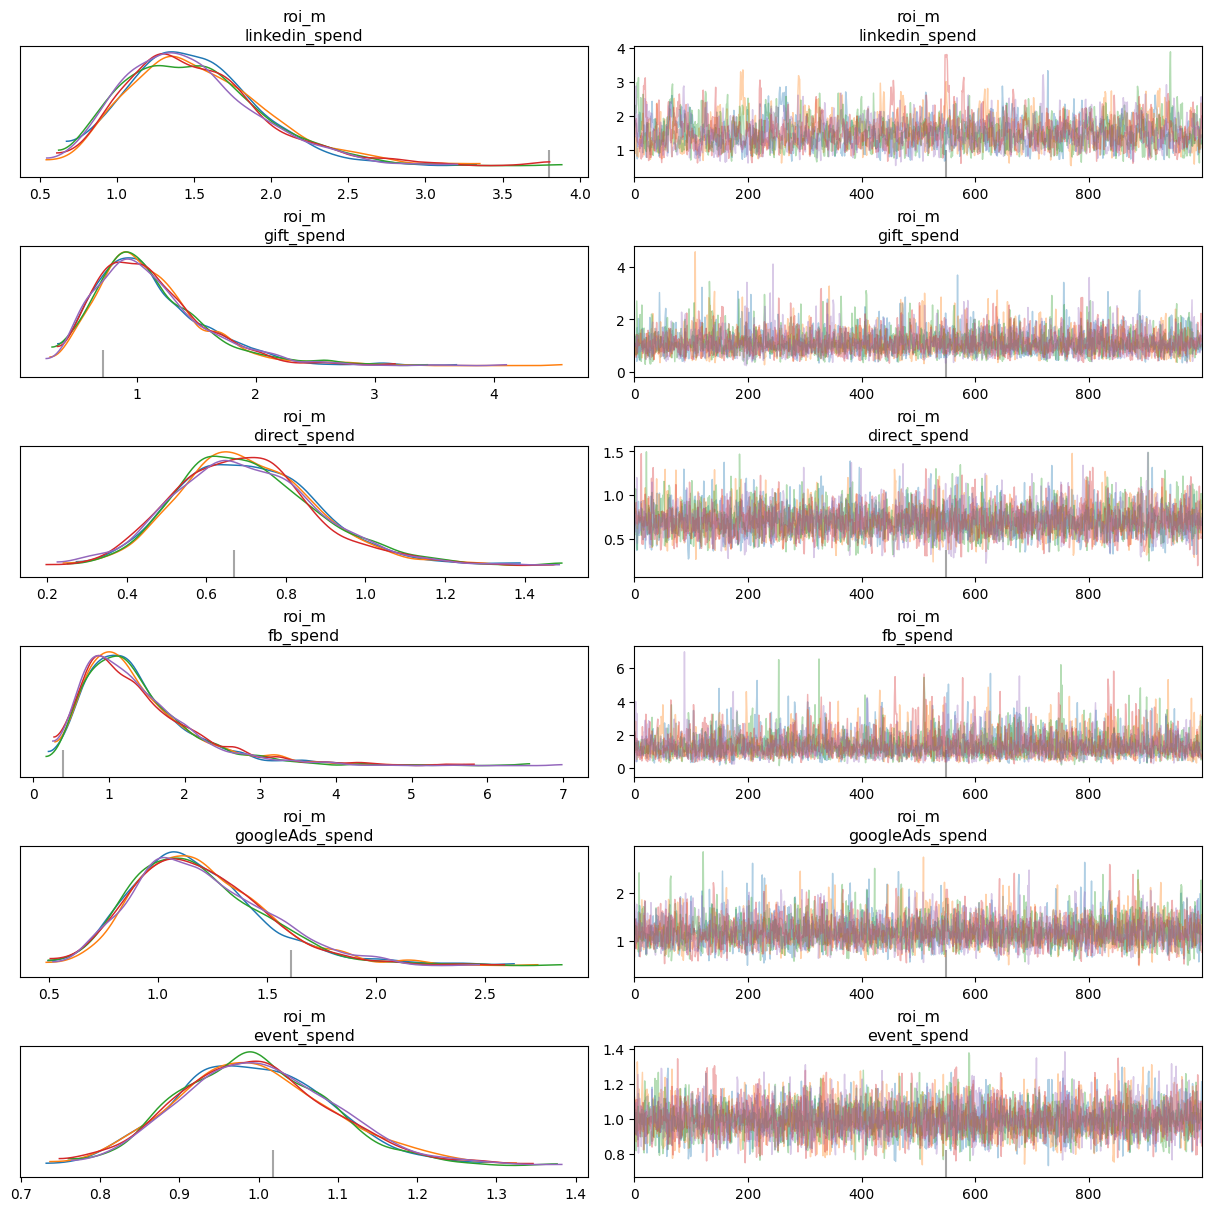

In [172]:
print(['linkedin_spend', 'gift_spend', 'direct_spend', 'fb_spend',
       'googleAds_spend', 'event_spend'])
print(roi_m)
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )


In [173]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

In [174]:
mmm.input_data.revenue_per_kpi

<xarray.DataArray 'revenue_per_kpi' (geo: 1, time: 335)> Size: 3kB
array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
Coordinates:
  * geo      (geo) <U12 48B 'national_geo'
  * time     (time) object 3kB '2024-04-11' '2024-04-12' ... '2025-03-11'

In [175]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()


/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:556: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


alt.LayerChart(...)

In [168]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:556: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


,metric,geo_granularity,value
0,R_Squared,national,0.379039
1,MAPE,national,0.345272
2,wMAPE,national,0.329700


In [166]:
media_summary = visualizer.MediaSummary(mmm)
media_summary.summary_table()


/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:855: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  return py_builtins.overload_of(f)(*args)
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/analysis/visualizer.py:1619: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .aggregate(lambda g: f'{g[0]} ({g[1]}, {g[2]})')


,channel,distribution,impressions,% impressions,spend,% spend,cpm,incremental outcome,% contribution,roi,effectiveness,mroi,cpik
0,linkedin_spend,prior,"3,841,929",51%,"$3,841,929",51%,"$1,000","$5,339,212 ($3,136,629, $8,366,674)","17.3% (10.2%, 27.1%)","1.4 (0.8, 2.2)","1.39 (0.82, 2.18)","0.7 (0.2, 1.2)","$0.8 ($0.5, $1.2)"
1,linkedin_spend,posterior,"3,841,929",51%,"$3,841,929",51%,"$1,000","$5,389,540 ($3,218,679, $8,153,121)","28.6% (17.1%, 43.2%)","1.4 (0.8, 2.1)","1.40 (0.84, 2.12)","0.7 (0.2, 1.2)","$0.7 ($0.5, $1.2)"
2,gift_spend,prior,"89,413",1%,"$89,413",1%,"$1,000","$94,599 ($49,152, $169,917)","0.3% (0.2%, 0.6%)","1.1 (0.5, 1.9)","1.06 (0.55, 1.90)","0.5 (0.2, 0.9)","$1.0 ($0.5, $1.8)"
3,gift_spend,posterior,"89,413",1%,"$89,413",1%,"$1,000","$99,172 ($48,534, $174,174)","0.5% (0.3%, 0.9%)","1.1 (0.5, 1.9)","1.11 (0.54, 1.95)","0.5 (0.2, 1.0)","$1.0 ($0.5, $1.8)"
4,direct_spend,prior,"1,070,271",14%,"$1,070,271",14%,"$1,000","$1,218,615 ($551,835, $2,353,144)","3.9% (1.8%, 7.6%)","1.1 (0.5, 2.2)","1.14 (0.52, 2.20)","0.6 (0.2, 1.2)","$1.0 ($0.5, $1.9)"
5,direct_spend,posterior,"1,070,271",14%,"$1,070,271",14%,"$1,000","$719,522 ($444,975, $1,033,990)","3.8% (2.4%, 5.5%)","0.7 (0.4, 1.0)","0.67 (0.42, 0.97)","0.3 (0.2, 0.5)","$1.5 ($1.0, $2.4)"
6,fb_spend,prior,"679,517",9%,"$679,517",9%,"$1,000","$832,672 ($323,913, $1,687,031)","2.7% (1.0%, 5.5%)","1.2 (0.5, 2.5)","1.23 (0.48, 2.48)","0.6 (0.2, 1.2)","$0.9 ($0.4, $2.1)"
7,fb_spend,posterior,"679,517",9%,"$679,517",9%,"$1,000","$910,612 ($336,710, $1,816,762)","4.8% (1.8%, 9.6%)","1.3 (0.5, 2.7)","1.34 (0.50, 2.67)","0.6 (0.2, 1.4)","$0.8 ($0.4, $2.0)"
8,googleAds_spend,prior,"1,568,982",21%,"$1,568,982",21%,"$1,000","$1,803,477 ($1,172,205, $2,604,767)","5.8% (3.8%, 8.4%)","1.1 (0.7, 1.7)","1.15 (0.75, 1.66)","0.5 (0.2, 0.9)","$0.9 ($0.6, $1.3)"
9,googleAds_spend,posterior,"1,568,982",21%,"$1,568,982",21%,"$1,000","$1,857,090 ($1,174,771, $2,728,186)","9.8% (6.2%, 14.5%)","1.2 (0.7, 1.7)","1.18 (0.75, 1.74)","0.6 (0.2, 1.0)","$0.9 ($0.6, $1.3)"


In [167]:

# Generate each individual chart and remove their individual config attributes to avoid conflicts on concatenation
media_summary.plot_contribution_waterfall_chart()


alt.LayerChart(...)

In [126]:
media_summary.plot_contribution_pie_chart()


alt.LayerChart(...)

In [127]:
media_summary.plot_spend_vs_contribution()


alt.FacetChart(...)

In [110]:
media_summary.plot_roi_bar_chart()


alt.LayerChart(...)

In [111]:
media_summary.plot_roi_vs_effectiveness()


alt.Chart(...)

In [ ]:
media_summary.plot_roi_vs_mroi()


In [ ]:
media_effects = visualizer.MediaEffects(mmm)
media_effects.plot_response_curves()

In [ ]:
## Get a read on the spend contribution by channel

In [ ]:
media_effects.plot_adstock_decay()


In [ ]:
media_summary = visualizer.MediaSummary(mmm)
media_summary.summary_table()


In [ ]:
media_summary.plot_spend_vs_contribution()


In [ ]:
media_summary.plot_roi_bar_chart()


In [ ]:
media_summary.plot_roi_vs_effectiveness()


In [ ]:
media_summary.plot_roi_vs_mroi()


In [ ]:
media_effects = visualizer.MediaEffects(mmm)
media_effects.plot_response_curves()

In [ ]:
media_effects = visualizer.MediaEffects(mmm)
media_effects.plot_response_curves(
    plot_separately=False,
    include_ci=False
)

In [ ]:
%%time
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()

filepath = '/content/drive/MyDrive'
optimization_results.output_optimization_summary('optimization_output.html', filepath)
IPython.display.HTML(filename='/content/drive/MyDrive/optimization_output.html')

# 3Day Average

In [ ]:
raw_data.columns

In [ ]:
data = raw_data[['date', 'podcast_streams', 'linkedin_spend', 'gSearch_sessions', 'linkedin_impressions', 
        'gift_spend', 'email_opened_cnt', 'direct_spend',
       'fb_spend','fb_impressions' ,'googleAds_spend', 'googleAds_impressions','event_spend', 'mql_count',
       'impactDotCom_ga4_sessions',  'daily_avg_queries', 'smoothed_MQL', 
       'inflation_rate','durable_goods_rates']].copy()
data['mql_count'] = data['mql_count'].fillna(0)
data['smoothed_MQL'] = data['smoothed_MQL'].fillna(0)
data['revenueProxy'] = data['smoothed_MQL'] * 1000
data['mql_gaus_smooth_sig1'] = gaussian_filter1d(data['mql_count'] , sigma=1)
data['mql_gaus_smooth_sig1_revenue'] = data['mql_gaus_smooth_sig1']*1000
data['mql_gaus_smooth_sig2'] = gaussian_filter1d(data['mql_count'] , sigma=2)
data['mql_gaus_smooth_sig2_revenue'] = data['mql_gaus_smooth_sig1']*1000
# data = data.dropna()




In [ ]:
# Assuming your DataFrame has a date column called 'date'
df = data.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Find gaps larger than 1 day
df['date_diff'] = df['date'].diff().dt.days
non_sequential = df[df['date_diff'] > 1]
print(non_sequential)

In [ ]:
# Data Load

In [ ]:
data.columns

In [ ]:
# STEP 2: LOAD AND PREPARE YOUR DATA

# Replace 'my_data.csv' with the path to your actual dataset
# data = pd.read_csv('/Users/gabriele/Downloads/dataset-ms - dataset-ms.csv')

# # Identify columns that contain spend-related keywords (e.g., 'spend', 'cost', 'budget')
media = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['spend', 'cost', 'budget'])
]
impressions = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['impressions'])
]

# Exclude media channels with zero total spend
media = [col for col in media if data[col].sum() > 0]

# Example: define any organic or additional columns you may want to handle
organic = ['podcast_streams', 'email_opened_cnt', 'impactDotCom_ga4_sessions']

# Print and verify selected media channels
print("Selected Media Channels:", media)

# # Convert date column to datetime
# data['date_week'] = pd.to_datetime(data['date_week'])
data['date_week'] =  data['date']

# # Identify the output (revenue) column(s)
# output = [
#     col for col in data.columns
#     if 'revenue' in col.lower()
# ]

# Identify the output (revenue) column(s)
output = [
    col for col in data.columns
    if 'mql_gaus_smooth_sig2_revenue' in col.lower()
]


# Create a time index t
data['t'] = range(len(data))

# Separate features (X) and target (y)
X = data.drop(output, axis=1)
y = data[output[0]]  # if there is only one revenue column

# Inspect columns
data.head()

## Collinearity

In [ ]:
# Import necessary libraries for visualization and multicollinearity analysis.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ----------------------------
# 1. Spend Share Analysis
# ----------------------------
print("******** Spend Share Analysis ********")
if media:
    # Calculate total spend across all identified media channels.
    total_media_spend = data[media].sum().sum()
    # Compute spend share for each media channel.
    spend_share = data[media].sum() / total_media_spend
    spend_share_df = spend_share.reset_index()
    spend_share_df.columns = ['Media_Channel', 'Spend_Share']
    print(spend_share_df)

    # Plot a bar chart of spend share.
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Spend_Share', y='Media_Channel',
                data=spend_share_df.sort_values(by='Spend_Share', ascending=False))
    plt.title("Spend Share by Media Channel")
    plt.xlabel("Spend Share")
    plt.ylabel("Media Channel")
    plt.show()
else:
    print("No media channels available for spend share analysis.")


# ----------------------------
# 2. Correlation Analysis between Inputs and Output (ecommerce_revenue)
# ----------------------------
print("\n******** Correlation Analysis ********")
# Determine the revenue column (assume that output[0] is the revenue column, as set previously)
revenue_col = output[0] if output and output[0] in data.columns else 'ecommerce_revenue'
print("Using revenue column:", revenue_col)

# Select only numeric features from the complete dataset.
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

if revenue_col in corr_matrix.columns:
    # Calculate correlation of all numeric features with the revenue column.
    corr_with_rev = corr_matrix[revenue_col].drop(labels=[revenue_col]).sort_values(ascending=False)
    print("Correlation of inputs with {}:".format(revenue_col))
    print(corr_with_rev)

    # Identify top 10 features most correlated (by absolute value) with the revenue.
    top_features = corr_with_rev.abs().sort_values(ascending=False).head(10).index.tolist() + [revenue_col]

    # Plot a heatmap displaying correlations among these top features.
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_data[top_features].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title("Heatmap of Top Correlated Features with {}".format(revenue_col))
    plt.show()
else:
    print("Revenue column not found in the correlation matrix.")


# ----------------------------
# 3. Multicollinearity Analysis (Variance Inflation Factor)
# ----------------------------
print("\n******** Multicollinearity Analysis ********")
# Use the feature set X defined earlier; select only numeric columns.
X_numeric = X.select_dtypes(include=[np.number])
if not X_numeric.empty:
    vif_df = pd.DataFrame()
    vif_df["Feature"] = X_numeric.columns
    # Calculate VIF for each feature.
    vif_df["VIF"] = [variance_inflation_factor(X_numeric.values, i)
                     for i in range(X_numeric.shape[1])]
    print(vif_df.sort_values(by="VIF", ascending=False))
else:
    print("No numeric features available in X for multicollinearity analysis.")


# ----------------------------
# 4. Check for Variables with Less Than 15 Records
# ----------------------------
print("\n******** Variables with Less Than 15 Records ********")
low_record_columns = {col: data[col].count() for col in data.columns if data[col].count() < 15}
if low_record_columns:
    for col, cnt in low_record_columns.items():
        print(f"Column '{col}' has only {cnt} recorded non-null entries.")
else:
    print("All variables have at least 15 records.")


In [ ]:
# Channel Mappings and Seasonality

In [ ]:
def create_channel_mappings(media, impressions):
    """
    Generate mapping dictionaries for media spend and impressions columns.

    Parameters:
        media (list of str): List of column names with spend/cost data.
                             Expected to have columns ending with '_cost'.
        impressions (list of str): List of column names with impressions data.
                                   Expected to have columns ending with '_cost_impressions'.

    Returns:
        tuple: Two dictionaries:
            - correct_media_spend_to_channel: Mapping of cost column names to simplified channel names.
            - correct_media_to_channel: Mapping of impressions column names to simplified channel names.
    """
    correct_media_spend_to_channel = {}
    for col in media:
        if col.endswith("_cost"):
            channel_name = col[:-len("_cost")]
        else:
            channel_name = col
        correct_media_spend_to_channel[col] = channel_name

    correct_media_to_channel = {}
    for col in impressions:
        if col.endswith("_impressions"):
          #substitute
            channel_name = col[:-len("_impressions")]
        else:
            channel_name = col
        correct_media_to_channel[col] = channel_name

    return correct_media_spend_to_channel, correct_media_to_channel



cost_mapping, impressions_mapping = create_channel_mappings(media, impressions)
print("Cost Mapping:", cost_mapping)
print("Impressions Mapping:", impressions_mapping)

In [ ]:
# def create_seasonality_features(data: pd.DataFrame, date_column: str, output_variable: str, yearly_seasonality: int) -> pd.DataFrame:
#     """
#     Creates seasonality effect features for modeling based on the yearly seasonality using the statsmodels library.

#     Parameters:
#     - data (pd.DataFrame): The input dataframe.
#     - date_column (str): The name of the date column.
#     - output_variable (str): The name of the output variable.
#     - yearly_seasonality (int): The yearly seasonality period (e.g., 52 for weekly, 365 for daily).

#     Returns:
#     - pd.DataFrame: The dataframe with added seasonality features.
#     """
#     from statsmodels.tsa.seasonal import seasonal_decompose

#     # Ensure the date column is in datetime format
#     data[date_column] = pd.to_datetime(data[date_column])

#     # Sort the data by date
#     data = data.sort_values(by=date_column)

#     # Set the date column as index for seasonal decomposition
#     data.set_index(date_column, inplace=True)

#     # Perform seasonal decomposition with multiplicative model
#     decomposition = seasonal_decompose(data[output_variable], model='multiplicative', period=yearly_seasonality)

#     # # Add seasonal component as a feature
#     data[f'seasonal_{output_variable}'] = decomposition.seasonal
#     # data[f'seasonal_{output_variable}'] = 1

#     # Reset index to retain the date column
#     data.reset_index(inplace=True)

#     return data

# # Example usage
# data = create_seasonality_features(
#     data,
#     date_column='date_week',
#     output_variable='mql_count',
#     yearly_seasonality=52
# )

# data.head()

In [ ]:
# Fix the mismatch in controls by renaming 'events' => 'events_events'
# (or whichever naming scheme you prefer if you actually want it to be 'events')

coord_to_columns = load.CoordToColumns(
    time='date',
    kpi='mql_gaus_smooth_sig2_revenue', 
    #revenue_per_kpi='revenueProxy',  # make sure this matches your KPI column in the DataFrame
    controls=['gSearch_sessions'],  # corrected name
    media=media,
    media_spend=media,
    organic_media=organic,  # or whichever email column you truly nee
)

loader = load.DataFrameDataLoader(
    df=data,
    kpi_type= 'revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=cost_mapping,
    media_spend_to_channel=cost_mapping,
)
data_meridian = loader.load()

In [ ]:
data_meridian.as_dataset()

In [ ]:

build_media_channel_args = data_meridian.get_paid_media_channels_argument_builder()

# Assuming Channel1,...,Channel6 are all media channels.
roi_m = build_media_channel_args(
  linkedin_spend=(0.20, 0.5),
  gift_spend=(0.01, 0.4),
  direct_spend=(0.01, 0.4),
  fb_spend=(0.10, 0.5),
  googleAds_spend=(0.10, 0.25),
  event_spend=(0.01, 0.1),
) # This creates a list of channel-ordered (mu, sigma) tuples.
roi_m_mu, roi_m_sigma = zip(*roi_m)

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(
        roi_m_mu, roi_m_sigma, name=constants.ROI_M
    )
)
model_spec = spec.ModelSpec(prior=prior, knots=4)
mmm = model.Meridian(input_data=data_meridian, model_spec=model_spec)

In [ ]:
mmm.sample_prior(500)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time


start_time = time.time()
# Remove progress_callback from the sample_posterior call
mmm.sample_posterior(
    n_chains=5,
    n_adapt=500,
    n_burnin=500,
    n_keep=1000,
    parallel_iterations=100,
    # progress_callback=update_progress  # Remove this line
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Runtime: {elapsed_time:.4f} seconds")

In [ ]:
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )


In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

In [ ]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()


In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

# Weekly Model

In [ ]:
from datetime import date, timedelta

def get_monday_of_week(input_date):
  """
  Returns the date of the Monday for the week containing the input_date.

  Args:
    input_date: A datetime.date object representing a date within the desired week.

  Returns:
    A datetime.date object representing the Monday of that week.
  """
  # Get the weekday of the input date (Monday is 0, Sunday is 6)
  day_of_week = input_date.weekday()

  # Calculate the difference in days to reach Monday
  days_to_monday = timedelta(days=day_of_week)

  # Subtract the difference to get the Monday's date
  monday_date = input_date - days_to_monday
  return monday_date

In [ ]:
data = raw_data[['date', 'podcast_streams', 'linkedin_spend', 'gSearch_sessions',
        'gift_spend', 'email_opened_cnt', 'direct_spend',
       'fb_spend','googleAds_spend','event_spend', 'mql_count',
       'impactDotCom_ga4_sessions',  'daily_avg_queries', 'smoothed_MQL',   'consumer_sentiment_index',
       'inflation_rate','durable_goods_rates']].copy()
data['mql_count'] = data['mql_count'].fillna(0)
data['smoothed_MQL'] = data['smoothed_MQL'].fillna(0)
data['revenueProxy'] = data['smoothed_MQL'] * 1000
data['date'] =  data['date'].apply(lambda x:  datetime.datetime.strptime(x,"%Y-%m-%d"))
data['monday_date'] =  data['date'].apply(lambda x:  get_monday_of_week(x))


In [ ]:
data['iso_week'] = data['date'].apply(lambda x: x.isocalendar().week)
data['iso_year'] = data['date'].apply(lambda x: x.isocalendar().year)
data['weekstr'] = data['iso_week'].apply(lambda x: '0' + str(x) if len(str(x))<2 else str(x))
data['yearstr'] = data['iso_year'].apply(lambda x: str(x))
data['model_week_str'] = data['yearstr'] + data['weekstr']
data['model_week'] =data['model_week_str'].apply(lambda x: int(x))

In [ ]:
sum_data=data[['model_week_str', 'podcast_streams', 'linkedin_spend', 'gSearch_sessions',
       'gift_spend', 'email_opened_cnt', 'direct_spend', 'fb_spend',
       'googleAds_spend', 'event_spend', 'mql_count',
       'impactDotCom_ga4_sessions']].groupby('model_week_str').sum().reset_index()
max_data=data[['model_week_str', 'daily_avg_queries', 'smoothed_MQL',   'consumer_sentiment_index',
       'inflation_rate','durable_goods_rates', 'monday_date']].groupby('model_week_str').max().reset_index()


In [ ]:
data =  pd.merge(sum_data, max_data, on='model_week_str')
data['revenueProxy'] = data['mql_count'] * 1000

In [ ]:
# STEP 2: LOAD AND PREPARE YOUR DATA

# Replace 'my_data.csv' with the path to your actual dataset
# data = pd.read_csv('/Users/gabriele/Downloads/dataset-ms - dataset-ms.csv')

# # Identify columns that contain spend-related keywords (e.g., 'spend', 'cost', 'budget')
media = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['spend', 'cost', 'budget'])
]

# Exclude media channels with zero total spend
media = [col for col in media if data[col].sum() > 0]

# Example: define any organic or additional columns you may want to handle
organic = ['podcast_streams', 'email_opened_cnt', 'impactDotCom_ga4_sessions']

# Print and verify selected media channels
print("Selected Media Channels:", media)

# # Convert date column to datetime
# data['date_week'] = pd.to_datetime(data['date_week'])
data['date_week'] =  data['monday_date']

# # Identify the output (revenue) column(s)
# output = [
#     col for col in data.columns
#     if 'revenue' in col.lower()
# ]

# Identify the output (revenue) column(s)
output = [
    col for col in data.columns
    if 'revenueproxy' in col.lower()
]


# Create a time index t
data['t'] = range(len(data))

# Separate features (X) and target (y)
X = data.drop(output, axis=1)
y = data[output[0]]  # if there is only one revenue column

# Inspect columns
data.head()

In [ ]:
data

# Collinearity

In [ ]:
# Import necessary libraries for visualization and multicollinearity analysis.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ----------------------------
# 1. Spend Share Analysis
# ----------------------------
print("******** Spend Share Analysis ********")
if media:
    # Calculate total spend across all identified media channels.
    total_media_spend = data[media].sum().sum()
    # Compute spend share for each media channel.
    spend_share = data[media].sum() / total_media_spend
    spend_share_df = spend_share.reset_index()
    spend_share_df.columns = ['Media_Channel', 'Spend_Share']
    print(spend_share_df)

    # Plot a bar chart of spend share.
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Spend_Share', y='Media_Channel',
                data=spend_share_df.sort_values(by='Spend_Share', ascending=False))
    plt.title("Spend Share by Media Channel")
    plt.xlabel("Spend Share")
    plt.ylabel("Media Channel")
    plt.show()
else:
    print("No media channels available for spend share analysis.")


# ----------------------------
# 2. Correlation Analysis between Inputs and Output (ecommerce_revenue)
# ----------------------------
print("\n******** Correlation Analysis ********")
# Determine the revenue column (assume that output[0] is the revenue column, as set previously)
revenue_col = output[0] if output and output[0] in data.columns else 'ecommerce_revenue'
print("Using revenue column:", revenue_col)

# Select only numeric features from the complete dataset.
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

if revenue_col in corr_matrix.columns:
    # Calculate correlation of all numeric features with the revenue column.
    corr_with_rev = corr_matrix[revenue_col].drop(labels=[revenue_col]).sort_values(ascending=False)
    print("Correlation of inputs with {}:".format(revenue_col))
    print(corr_with_rev)

    # Identify top 10 features most correlated (by absolute value) with the revenue.
    top_features = corr_with_rev.abs().sort_values(ascending=False).head(10).index.tolist() + [revenue_col]

    # Plot a heatmap displaying correlations among these top features.
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_data[top_features].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title("Heatmap of Top Correlated Features with {}".format(revenue_col))
    plt.show()
else:
    print("Revenue column not found in the correlation matrix.")


# ----------------------------
# 3. Multicollinearity Analysis (Variance Inflation Factor)
# ----------------------------
print("\n******** Multicollinearity Analysis ********")
# Use the feature set X defined earlier; select only numeric columns.
X_numeric = X.select_dtypes(include=[np.number])
if not X_numeric.empty:
    vif_df = pd.DataFrame()
    vif_df["Feature"] = X_numeric.columns
    # Calculate VIF for each feature.
    vif_df["VIF"] = [variance_inflation_factor(X_numeric.values, i)
                     for i in range(X_numeric.shape[1])]
    print(vif_df.sort_values(by="VIF", ascending=False))
else:
    print("No numeric features available in X for multicollinearity analysis.")


# ----------------------------
# 4. Check for Variables with Less Than 15 Records
# ----------------------------
print("\n******** Variables with Less Than 15 Records ********")
low_record_columns = {col: data[col].count() for col in data.columns if data[col].count() < 15}
if low_record_columns:
    for col, cnt in low_record_columns.items():
        print(f"Column '{col}' has only {cnt} recorded non-null entries.")
else:
    print("All variables have at least 15 records.")


In [ ]:
# Channel Mappings and Seasonality

In [ ]:
def create_channel_mappings(media, impressions):
    """
    Generate mapping dictionaries for media spend and impressions columns.

    Parameters:
        media (list of str): List of column names with spend/cost data.
                             Expected to have columns ending with '_cost'.
        impressions (list of str): List of column names with impressions data.
                                   Expected to have columns ending with '_cost_impressions'.

    Returns:
        tuple: Two dictionaries:
            - correct_media_spend_to_channel: Mapping of cost column names to simplified channel names.
            - correct_media_to_channel: Mapping of impressions column names to simplified channel names.
    """
    correct_media_spend_to_channel = {}
    for col in media:
        if col.endswith("_cost"):
            channel_name = col[:-len("_cost")]
        else:
            channel_name = col
        correct_media_spend_to_channel[col] = channel_name

    correct_media_to_channel = {}
    for col in impressions:
        if col.endswith("_impressions"):
          #substitute
            channel_name = col[:-len("_impressions")]
        else:
            channel_name = col
        correct_media_to_channel[col] = channel_name

    return correct_media_spend_to_channel, correct_media_to_channel



cost_mapping, impressions_mapping = create_channel_mappings(media, media)
print("Cost Mapping:", cost_mapping)
print("Impressions Mapping:", impressions_mapping)

In [ ]:
# def create_seasonality_features(data: pd.DataFrame, date_column: str, output_variable: str, yearly_seasonality: int) -> pd.DataFrame:
#     """
#     Creates seasonality effect features for modeling based on the yearly seasonality using the statsmodels library.

#     Parameters:
#     - data (pd.DataFrame): The input dataframe.
#     - date_column (str): The name of the date column.
#     - output_variable (str): The name of the output variable.
#     - yearly_seasonality (int): The yearly seasonality period (e.g., 52 for weekly, 365 for daily).

#     Returns:
#     - pd.DataFrame: The dataframe with added seasonality features.
#     """
#     from statsmodels.tsa.seasonal import seasonal_decompose

#     # Ensure the date column is in datetime format
#     data[date_column] = pd.to_datetime(data[date_column])

#     # Sort the data by date
#     data = data.sort_values(by=date_column)

#     # Set the date column as index for seasonal decomposition
#     data.set_index(date_column, inplace=True)

#     # Perform seasonal decomposition with multiplicative model
#     decomposition = seasonal_decompose(data[output_variable], model='multiplicative', period=yearly_seasonality)

#     # # Add seasonal component as a feature
#     data[f'seasonal_{output_variable}'] = decomposition.seasonal
#     # data[f'seasonal_{output_variable}'] = 1

#     # Reset index to retain the date column
#     data.reset_index(inplace=True)

#     return data

# # Example usage
# data = create_seasonality_features(
#     data,
#     date_column='date_week',
#     output_variable='mql_count',
#     yearly_seasonality=52
# )

data.head()

In [ ]:
data[data['consumer_sentiment_index'].isnull()==True]

In [ ]:
yearEndCols = ['consumer_sentiment_index', 'durable_goods_rates','inflation_rate' ]
for col in yearEndCols:
    print(data[data[col].isnull()==True])

In [ ]:
# data = data[['podcast_streams', 'linkedin_spend', 'gSearch_sessions',
#        'gift_spend', 'email_opened_cnt', 'direct_spend', 'fb_spend',
#        'googleAds_spend', 'event_spend', 'mql_count',
#        'impactDotCom_ga4_sessions', 'daily_avg_queries', 'smoothed_MQL',
#        'consumer_sentiment_index', 'inflation_rate', 'durable_goods_rates',
#        'revenueProxy', 'date_week']]

In [ ]:
data['date_week']

In [ ]:
# Fix the mismatch in controls by renaming 'events' => 'events_events'
# (or whichever naming scheme you prefer if you actually want it to be 'events')

coord_to_columns = load.CoordToColumns(
    time='monday_date',
    kpi='revenueProxy',   # make sure this matches your KPI column in the DataFrame
    controls=['gSearch_sessions'],  # corrected name
    media=media,
    media_spend=media,
    organic_media=organic,  # or whichever email column you truly nee
)

loader = load.DataFrameDataLoader(
    df=data,
    kpi_type= 'revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=cost_mapping,
    media_spend_to_channel=cost_mapping,
)
data_meridian = loader.load()

In [ ]:
data_meridian.as_dataset()

In [ ]:

build_media_channel_args = data_meridian.get_paid_media_channels_argument_builder()

# Assuming Channel1,...,Channel6 are all media channels.
roi_m = build_media_channel_args(
  linkedin_spend=(0.10, 0.7),
  gift_spend=(0.01, 0.7),
  direct_spend=(0.01, 0.6),
  fb_spend=(0.05, 0.7),
  googleAds_spend=(0.10, 0.6),
  event_spend=(0.01, 0.5),
) # This creates a list of channel-ordered (mu, sigma) tuples.
roi_m_mu, roi_m_sigma = zip(*roi_m)

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(
        roi_m_mu, roi_m_sigma, name=constants.ROI_M
    )
)
model_spec = spec.ModelSpec(prior=prior)
mmm = model.Meridian(input_data=data_meridian, model_spec=model_spec)

In [ ]:
mmm.sample_prior(500)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time


start_time = time.time()
# Remove progress_callback from the sample_posterior call
mmm.sample_posterior(
    n_chains=5,
    n_adapt=500,
    n_burnin=500,
    n_keep=1000,
    parallel_iterations=100,
    # progress_callback=update_progress  # Remove this line
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Runtime: {elapsed_time:.4f} seconds")

In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

In [ ]:
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )


In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

In [ ]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()


In [ ]:
media_summary = visualizer.MediaSummary(mmm)
media_summary.summary_table()


In [ ]:

# Generate each individual chart and remove their individual config attributes to avoid conflicts on concatenation
media_summary.plot_contribution_waterfall_chart()


In [ ]:
media_summary.plot_contribution_pie_chart()


In [ ]:
media_summary.plot_spend_vs_contribution()


In [ ]:
media_summary.plot_roi_bar_chart()


In [ ]:
media_summary.plot_roi_vs_effectiveness()


In [ ]:
media_summary.plot_roi_vs_mroi()


In [ ]:
media_effects = visualizer.MediaEffects(mmm)
media_effects.plot_response_curves()

In [ ]:
media_effects.plot_adstock_decay()


In [ ]:
# Get last 4 weeks of data
last_4_weeks = data['date_week'][-4:].values

print("Last 4 weeks:")
for week in last_4_weeks:
    print(week)

# Calculate total media spend in last 4 weeks
last_4_weeks_spend = data[media].iloc[-4:]

print("\nTotal media spend in last 4 weeks:")
for week, spend in zip(last_4_weeks, last_4_weeks_spend):
    print(week,spend)

print(last_4_weeks_spend.sum().sum())

print(len(media))

In [ ]:
data


budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize(
      selected_times=('2024-01-01', '2024-01-22'),
      budget=32733,
      spend_constraint_lower=[0.3, 0.2, 0.3, 0.3, 0.3, 0.2, 0.3, 0.2, 0.3, 0.3, 0.3, 0.2],
      spend_constraint_upper=[0.3, 0.2, 0.3, 0.3, 0.3, 0.2, 0.3, 0.2, 0.3, 0.3, 0.3, 0.2],
)

In [ ]:
optimization_results.nonoptimized_data

In [ ]:
optimization_results.optimized_data


In [ ]:
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()

In [ ]:
media_effects = visualizer.MediaEffects(mmm)
media_effects.plot_response_curves()

In [ ]:
media_effects.plot_adstock_decay()


In [ ]:
# Get last 4 weeks of data
last_4_weeks = data['date_week'][-4:].values

print("Last 4 weeks:")
for week in last_4_weeks:
    print(week)

# Calculate total media spend in last 4 weeks
last_4_weeks_spend = data[media].iloc[-4:]

print("\nTotal media spend in last 4 weeks:")
for week, spend in zip(last_4_weeks, last_4_weeks_spend):
    print(week,spend)

print(last_4_weeks_spend.sum().sum())

print(len(media))

In [ ]:
data


budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize(
      selected_times=('2024-01-01', '2024-01-22'),
      budget=32733,
      spend_constraint_lower=[0.3, 0.2, 0.3, 0.3, 0.3, 0.2, 0.3, 0.2, 0.3, 0.3, 0.3, 0.2],
      spend_constraint_upper=[0.3, 0.2, 0.3, 0.3, 0.3, 0.2, 0.3, 0.2, 0.3, 0.3, 0.3, 0.2],
)

optimization_results.nonoptimized_data

optimization_results.optimized_data

budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()